<a href="https://colab.research.google.com/github/YusunPark/move_bike/blob/main/%EB%94%B0%EB%A6%89%EC%9D%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 준비


In [ ]:
!pip install pymysql
!pip3 install feature-engine==1.1.2 scikit-learn==1.0.0 imbalanced-learn==0.8.1

import pandas as pd
import numpy as np
import pymysql
from sklearn.preprocessing import MinMaxScaler
from feature_engine.encoding import OneHotEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt
import seaborn as sns
import gc


     |████████████████████████████████| 43 kB 587 kB/s 
     |████████████████████████████████| 180 kB 7.3 MB/s 
     |████████████████████████████████| 23.1 MB 2.5 MB/s 
     |████████████████████████████████| 9.8 MB 8.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:
w_QUERY = "select * from weather where date between '2022-04-28' and '2022-05-01';"
b_QUERY = "select * from bike where date between '2022-04-28' and '2022-05-01';"

In [ ]:
conn = pymysql.connect(
    host='158.247.209.211', 
    port=3306,
    user='root',
    passwd='insight2022',
    db='insight',
    charset='utf8',
    autocommit=False
)

cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)

# for value in data:
cursor.execute(w_QUERY)
weather_data = cursor.fetchall()
weather_df = pd.DataFrame.from_dict(weather_data)

cursor.execute(b_QUERY)
bike_data = cursor.fetchall()
bike_df = pd.DataFrame.from_dict(bike_data)

# conn.commit()
cursor.close()
conn.close()


In [ ]:
bike_df['month']=bike_df['date'].dt.month
bike_df['day']=bike_df['date'].dt.day
bike_df['weekday']=bike_df['date'].dt.weekday
bike_df['hour'] = bike_df['date'].dt.hour
bike_df['time_only']=bike_df['date'].dt.time

weather_df['hour'] = weather_df['date'].dt.hour

bike_df.head()

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date,month,day,weekday,hour,time_only
0,11833739,20,11,55,ST-4,2022-04-28 00:00:02,4,28,3,0,00:00:02
1,11833740,14,26,186,ST-5,2022-04-28 00:00:02,4,28,3,0,00:00:02
2,11833741,13,0,0,ST-6,2022-04-28 00:00:02,4,28,3,0,00:00:02
3,11833742,5,0,0,ST-7,2022-04-28 00:00:02,4,28,3,0,00:00:02
4,11833743,12,2,17,ST-8,2022-04-28 00:00:02,4,28,3,0,00:00:02


In [ ]:
# 주말 : 1, 평일 : 0

weekend = []

for i in bike_df['weekday']:
  if 0 <= i <= 4:
    weekend.append(0)
  else:
    weekend.append(1)
 

bike_df['weekend']=weekend
bike_df.head()

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date,month,day,weekday,hour,time_only,weekend
0,11833739,20,11,55,ST-4,2022-04-28 00:00:02,4,28,3,0,00:00:02,0
1,11833740,14,26,186,ST-5,2022-04-28 00:00:02,4,28,3,0,00:00:02,0
2,11833741,13,0,0,ST-6,2022-04-28 00:00:02,4,28,3,0,00:00:02,0
3,11833742,5,0,0,ST-7,2022-04-28 00:00:02,4,28,3,0,00:00:02,0
4,11833743,12,2,17,ST-8,2022-04-28 00:00:02,4,28,3,0,00:00:02,0


In [ ]:
# 봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3

season = []

for i in bike_df['month']:
  if 3 <= i <= 5:
    season.append(0)
  elif 6 <= i <= 8:
    season.append(1)
  elif 9 <= i <= 11:
    season.append(2)
  else:
    season.append(3)

bike_df['season']=season
bike_df.head()

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,date,month,day,weekday,hour,time_only,weekend,season
0,11833739,20,11,55,ST-4,2022-04-28 00:00:02,4,28,3,0,00:00:02,0,0
1,11833740,14,26,186,ST-5,2022-04-28 00:00:02,4,28,3,0,00:00:02,0,0
2,11833741,13,0,0,ST-6,2022-04-28 00:00:02,4,28,3,0,00:00:02,0,0
3,11833742,5,0,0,ST-7,2022-04-28 00:00:02,4,28,3,0,00:00:02,0,0
4,11833743,12,2,17,ST-8,2022-04-28 00:00:02,4,28,3,0,00:00:02,0,0


In [ ]:
# 기후에 대한 값을 0, 1 로 나누어서 저장 (맑은 날 1, 흐린 날 0) - clouds 까지 1로 할지 논의 필요

weather_df.loc[weather_df.main=='Clear','main']=1
weather_df.loc[weather_df.main=='Clouds','main']=1
weather_df.loc[weather_df.main=='Thunderstorm','main']=0
weather_df.loc[weather_df.main=='Drizzle','main']=0
weather_df.loc[weather_df.main=='Rain','main']=0
weather_df.loc[weather_df.main=='Snow','main']=0
weather_df.loc[weather_df.main=='Mist','main']=0
weather_df.loc[weather_df.main=='Smoke','main']=0
weather_df.loc[weather_df.main=='Haze','main']=0
weather_df.loc[weather_df.main=='Dust','main']=0
weather_df.loc[weather_df.main=='Fog','main']=0
weather_df.loc[weather_df.main=='Sand','main']=0
weather_df.loc[weather_df.main=='Ash','main']=0
weather_df.loc[weather_df.main=='Squall','main']=0
weather_df.loc[weather_df.main=='Tornado','main']=0

In [ ]:
# 학습에 필요한 데이터 생성.

data = pd.merge(bike_df, weather_df.drop(['date'],axis=1), on='hour', how='left')
data = data.set_index('date')
data['main'] = pd.to_numeric(data['main'])

data

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,month,day,weekday,hour,time_only,weekend,season,main,temp,feels_like,wind_speed
date,,,,,,,,,,,,,,,,
2022-04-28 00:00:02,11833739,20,11,55,ST-4,4,28,3,0,00:00:02,0,0,1,12.32,11.07,1.54
2022-04-28 00:00:02,11833739,20,11,55,ST-4,4,28,3,0,00:00:02,0,0,0,14.74,13.68,3.66
2022-04-28 00:00:02,11833739,20,11,55,ST-4,4,28,3,0,00:00:02,0,0,1,12.31,11.11,2.06
2022-04-28 00:00:02,11833740,14,26,186,ST-5,4,28,3,0,00:00:02,0,0,1,12.32,11.07,1.54
2022-04-28 00:00:02,11833740,14,26,186,ST-5,4,28,3,0,00:00:02,0,0,0,14.74,13.68,3.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30 20:30:02,16034947,7,4,57,ST-3041,4,30,5,20,20:30:02,1,0,1,14.74,13.65,3.42
2022-04-30 20:30:02,16034947,7,4,57,ST-3041,4,30,5,20,20:30:02,1,0,1,12.61,11.73,3.60
2022-04-30 20:30:02,16034948,2,2,100,ST-1747,4,30,5,20,20:30:02,1,0,1,17.37,16.15,3.09


In [ ]:
del bike_df 
del weather_df 

del bike_data
del weather_data

gc.collect()


79

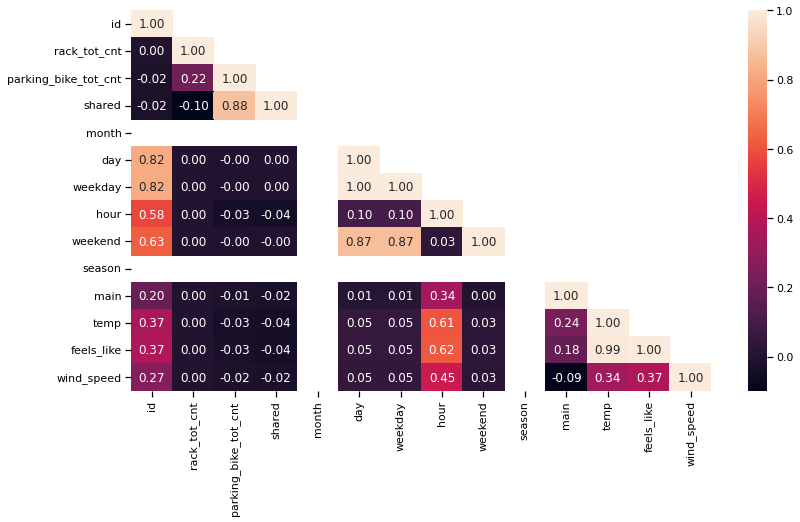

In [ ]:
# Correlation with heat map
corr = data.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=0)

In [ ]:
# 중복 데이터 record 확인
data[data.duplicated(keep = False)]

,id,rack_tot_cnt,parking_bike_tot_cnt,shared,station_id,month,day,weekday,hour,time_only,weekend,season,main,temp,feels_like,wind_speed
date,,,,,,,,,,,,,,,,


## X, Y 데이터 분리하기


In [ ]:
X = data.drop(['parking_bike_tot_cnt', 'id', 'time_only', 'station_id'], axis=1)
Y = data['parking_bike_tot_cnt']

In [ ]:
# 라벨 값의 비율 확인 
Y.value_counts()

0      1902067
1      1180137
2       862705
3       689169
4       576753
        ...   
146         15
122         15
118         12
142         12
159         12
Name: parking_bike_tot_cnt, Length: 169, dtype: int64

In [ ]:
ohencoder = OneHotEncoder(variables=['season'])
X['season'] = X['season'].astype(str)
X = ohencoder.fit_transform(X)

## train / test 분리


In [ ]:
# train, test 7:3 분리
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=20, stratify=Y)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [ ]:
X_test.shape

(3725210, 12)

In [ ]:
print("Train ratio of X:", X_train.shape[0] / X.shape[0])
print("Test ratio of X:", X_test.shape[0] / X.shape[0])

Train ratio of X: 0.6999999838935246
Test ratio of X: 0.3000000161064754


## Scaler

In [ ]:
del data
del X
del Y
gc.collect()

223

In [ ]:
# scale 이 필요한 컬럼들
needScale = ['temp', 'feels_like', 'wind_speed', 'rack_tot_cnt', 'shared']

In [ ]:
X_train_temp_row = X_train
X_test_temp_row = X_test

In [ ]:
X_train = X_train_temp_row
X_test = X_test_temp_row


In [ ]:
MMS = MinMaxScaler()

for column in needScale:
    X_train[column] = MMS.fit_transform(X_train[column].to_numpy().reshape(-1, 1))
    X_test[column] = MMS.transform(X_test[column].to_numpy().reshape(-1, 1))

In [ ]:
X_train

,rack_tot_cnt,shared,month,day,weekday,hour,weekend,main,temp,feels_like,wind_speed,season_0
0,0.181818,0.036515,4,28,3,19,0,0,0.328398,0.332003,0.483019,1
1,0.136364,0.052165,4,29,4,6,0,0,0.135935,0.157685,0.467925,1
2,0.522727,0.095983,4,28,3,4,0,1,0.163526,0.151031,0.547170,1
3,0.181818,0.036515,4,28,3,13,0,1,0.440108,0.439787,0.417610,1
4,0.227273,0.100156,4,28,3,11,0,1,0.267833,0.278110,0.362264,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8692151,0.181818,0.036515,4,28,3,11,0,1,0.402423,0.383234,0.276730,1
8692152,0.272727,0.059468,4,28,3,14,0,1,0.472409,0.473054,0.311950,1
8692153,0.068182,0.208659,4,28,3,8,0,0,0.133917,0.157019,0.288050,1
8692154,0.159091,0.000000,4,28,3,5,0,0,0.135935,0.161011,0.450314,1


## LightGBM

In [ ]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier( n_estimators=10, num_leaves=10, learning_rate = 0.3, objective='regression')
lgb_clf.fit(X_train, Y_train)
y_pred = lgb_clf.predict(X_test)
accuracy_score(Y_test, y_pred)

In [ ]:
# lgbm = LGBMClassifier(n_estimators=30, num_leaves=20, n_jobs=-1, boost_from_average=False, random_state=13)
# lgbm.fit(X_train, Y_train)
# lgbm_pred = lgbm.predict(X_test)

# print_clf_eval(Y_test, lgbm_pred)

## XG Boost

In [ ]:
from xgboost import plot_importance, plot_tree

XG_model_month = xgb.XGBRegressor(n_estimators=30)
XG_model_month.fit(X_train,Y_train, eval_set=[(X_test, Y_test)], early_stopping_rounds=50,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

In [ ]:
# #테스트 데이터 중 특정 store/item 데이터를 추출
# df1 = X_test[(X_test.store==1) & (X_test.item==2)]

# xgboost = XG_model_month.predict(df1)

# # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
# result=pd.concat([df_test_orig[(df_test_orig.store==1)&(df_test_orig.item==2)].reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
# result = result.loc[:, ['sales', 'xgboost']]
result.plot()

In [ ]:
# xgb=XGBClassifier(use_label_encoder=False,random_state=42,eval_metric='mlogloss')
# xgb.fit(X_train,Y_train)
# xgb_pred = xgb.predict(X_test)

# print_clf_eval(Y_test, xgb_pred)

# Summary : 성능평가

In [ ]:
# indexs = ['Keras MLP', 'Keras DNN', 'Keras logistic regression', 'Sklearn logistic regression', 'Sklearn Decision Tree', 'Sklearn RandomForest', 'LightGBM','XG Boost']
# columns = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
# temp = []

# temp.append(get_clf_eval(Y_test, model_mlp_pred))
# temp.append(get_clf_eval(Y_test, model_dnn_pred))
# temp.append(get_clf_eval(Y_test, model_log_pred))
# temp.append(get_clf_eval(Y_test, sk_log_pred))
# temp.append(get_clf_eval(Y_test, sk_tree_pred))
# temp.append(get_clf_eval(Y_test, sk_rf_pred))
# temp.append(get_clf_eval(Y_test, lgbm_pred))
# temp.append(get_clf_eval(Y_test, xgb_pred))

# results = pd.DataFrame(temp, index=indexs, columns=columns)
# results.sort_values(by=['F1-score'], axis=0, ascending=False)